In [443]:
from plot_lib import *
from experiment_lib import load_constants_from_config
import json

# parse config
path = "exp-configs/EMEA/epoch/1/config-2.7B-en.json"

with open(path, "r") as f:
    config = json.load(f)

# Load constants from config
(
    ROOT_DIR, 
    DATASET_DIR, 
    SOURCE_DIR, 
    DATASET_NAME, 
    EXPERIMENT_NAME, 
    NUM_TRIALS, 
    PREFIX_LEN, 
    SUFFIX_LEN, 
    PREPREFIX_LEN, 
    LANGUAGE, 
    SPLIT, 
    EXAMPLE_TOKEN_LEN, 
    SOURCE_FILE, 
    BATCH_SIZE, 
    MODEL_NAME, 
    TRAIN_FILE, 
    VAL_FILE, 
    VAL_SPLIT, 
    SEED
) = load_constants_from_config(config)

In [3]:
plot_max_BLEU(EXPERIMENT_NAME, MODEL_NAME, DATASET_DIR, LANGUAGE, EXAMPLE_TOKEN_LEN, PREFIX_LEN, NUM_TRIALS)

tmp/europarl/en/en-100-100-6B/bleu_scores/sorted_compl_bleu_scores.jsonl


FileNotFoundError: [Errno 2] No such file or directory: 'tmp/europarl/en/en-100-100-6B/bleu_scores/sorted_compl_bleu_scores.jsonl'

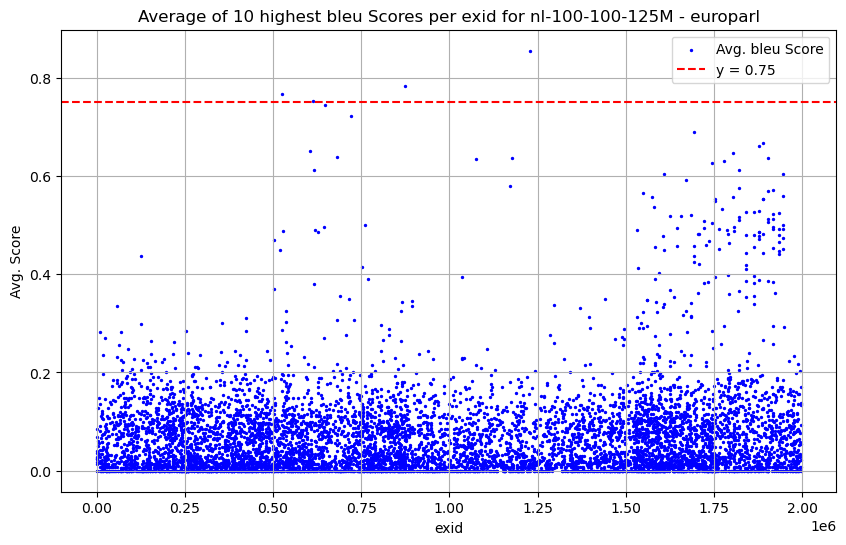

In [8]:
avg_10_highest_score(EXPERIMENT_NAME, MODEL_NAME, DATASET_DIR, LANGUAGE, EXAMPLE_TOKEN_LEN, PREFIX_LEN, NUM_TRIALS, isMeteor=False)

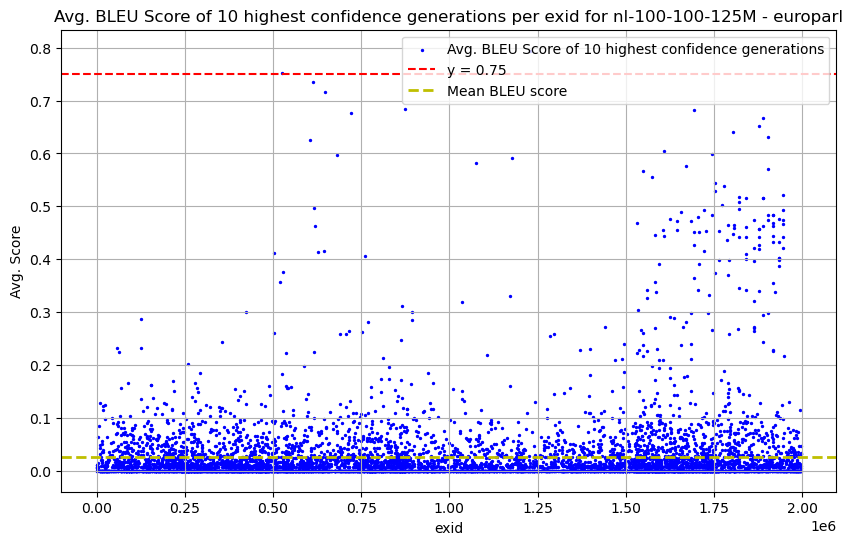

In [10]:
avg_10_highest_conf(EXPERIMENT_NAME, MODEL_NAME, DATASET_DIR, LANGUAGE, EXAMPLE_TOKEN_LEN, PREFIX_LEN, NUM_TRIALS)

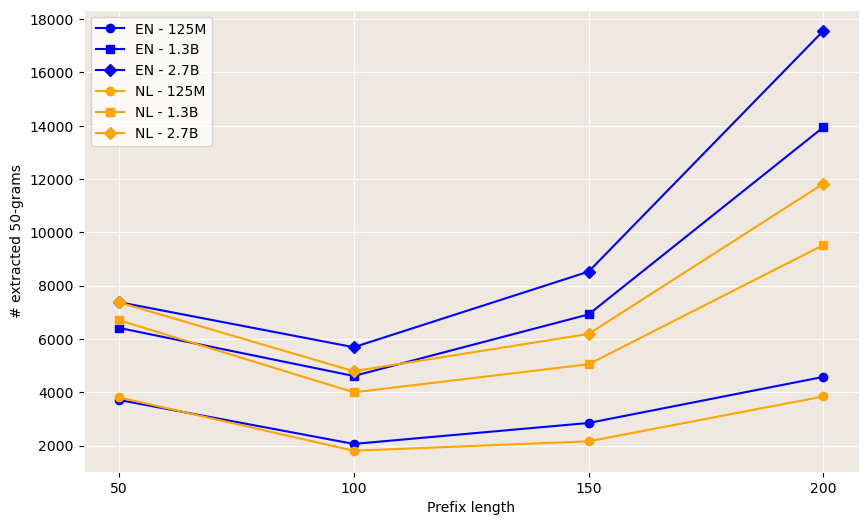

In [256]:
base = os.path.join(ROOT_DIR, DATASET_DIR)
model_sizes = ["125M", "1.3B", "2.7B"]
languages = ["en", "nl"]
context = [100, 150, 200, 250]

# Initialize a dictionary to hold scores
scores = {lang: {token_len: [] for token_len in context} for lang in languages}

# Collect scores
for lang in languages:
    for size in model_sizes:
        for token_len in context:
            acc_file = os.path.join(ROOT_DIR, DATASET_DIR, lang, f"{lang}-{token_len}-100-{size}", "accuracy.jsonl")
            with open(acc_file, 'r') as file:
                data = json.loads(file.readline())
                scores[lang][token_len].append((size, data['num_correct'], data['num_exact_match']))


# Reorganize data for plotting
scores_by_size = {lang: {size: [] for size in model_sizes} for lang in languages}
for lang in languages:
    for size in model_sizes:
        for token_len in context:
            _, num_correct, _ = scores[lang][token_len][model_sizes.index(size)]
            scores_by_size[lang][size].append((token_len, num_correct))

markers = ['o', 's', 'D', '^', 'h']
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for lang in languages:
    for size_index, size in enumerate(model_sizes):
        token_lens = [token_len -50  for token_len, _ in scores_by_size[lang][size]]
        corrects = [correct for _,  correct in scores_by_size[lang][size]]
        label = f'{lang.upper()} - {size}'
        color = 'blue' if lang == "en" else 'orange'
        marker = markers[size_index]
        ax.plot(token_lens, corrects, label=label, color=color, marker=marker)

ax.set_xlabel('Prefix length')
ax.set_ylabel('# extracted 50-grams')
ax.legend()
plt.grid(True, color='white')
ax.set_facecolor('#efe8e1')
ax.set_xticks([tl - 50 for tl in context])
ax.set_xticklabels([str(tl - 50) for tl in context])
for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.show()

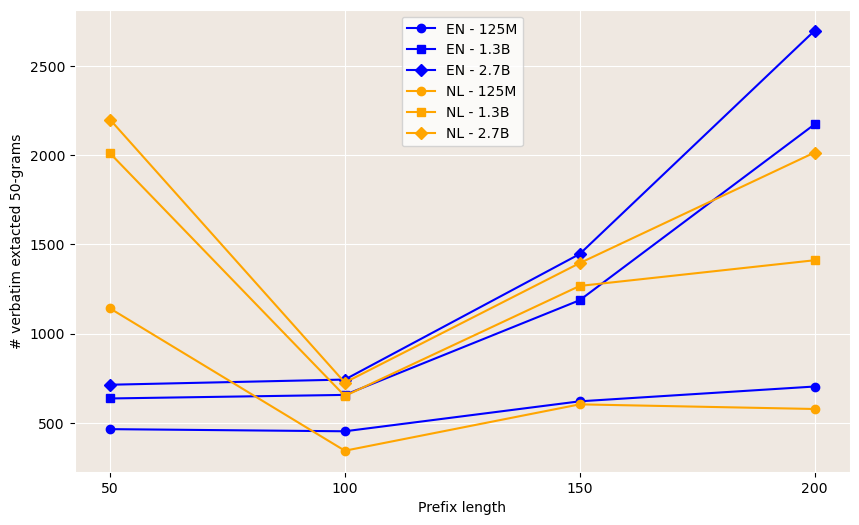

In [257]:
base = os.path.join(ROOT_DIR, DATASET_DIR)


model_sizes = ["125M", "1.3B", "2.7B"]
languages = ["en", "nl"]
context = [100, 150, 200, 250]

# Initialize a dictionary to hold scores
scores = {lang: {token_len: [] for token_len in context} for lang in languages}

# Collect scores
for lang in languages:
    for size in model_sizes:
        for token_len in context:
            acc_file = os.path.join(ROOT_DIR, DATASET_DIR, lang, f"{lang}-{token_len}-100-{size}", "accuracy.jsonl")
            with open(acc_file, 'r') as file:
                data = json.loads(file.readline())
                scores[lang][token_len].append((size, data['num_correct'], data['num_exact_match']))

# Reorganize data for plotting
scores_by_size = {lang: {size: [] for size in model_sizes} for lang in languages}
for lang in languages:
    for size in model_sizes:
        for token_len in context:
            _, _, num_em = scores[lang][token_len][model_sizes.index(size)]
            scores_by_size[lang][size].append((token_len, num_em))

markers = ['o', 's', 'D', '^', 'h']
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for lang in languages:
    for size_index, size in enumerate(model_sizes):
        token_lens = [token_len for token_len, _ in scores_by_size[lang][size]]
        exact_matches = [num_em for _, num_em in scores_by_size[lang][size]]
        label = f'{lang.upper()} - {size}'
        color = 'blue' if lang == "en" else 'orange'
        marker = markers[size_index]
        ax.plot(token_lens, exact_matches, label=label, color=color, marker=marker)

ax.set_xlabel('Prefix length')
ax.set_ylabel('# verbatim extacted 50-grams')
ax.legend()
plt.grid(True, color='white')
ax.set_facecolor('#efe8e1')
ax.set_xticks(context)
ax.set_xticklabels([str(tl-50) for tl in context])
for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.show()

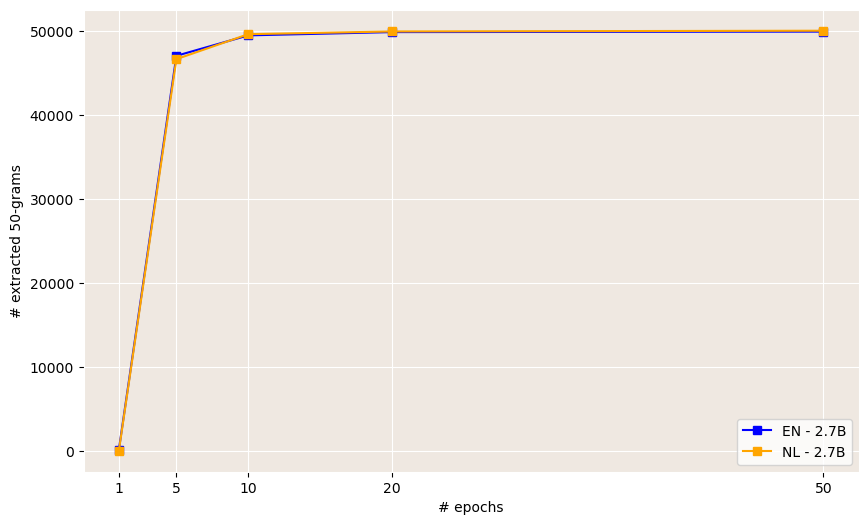

In [444]:
base = os.path.join(ROOT_DIR, DATASET_DIR)
languages = ["en", "nl"]
context = [1, 5, 10, 20, 50]
model_sizes = ["2.7B"]

# Initialize a dictionary to hold scores for each model size
scores = {lang: {size: {e: 0 for e in context} for size in model_sizes} for lang in languages}

# Collect scores
for lang in languages:
    for size in model_sizes:
        for e in context:
            acc_file = os.path.join(ROOT_DIR, DATASET_DIR, lang, f"{lang}-100-100-{size}-E{e}", "accuracy2.jsonl")
            with open(acc_file, 'r') as file:
                data = json.loads(file.readline())
                scores[lang][size][e] = data['num_correct']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each language
colors = {'en': 'blue', 'nl': 'orange'}
markers = ['s', 'D']  # Keep the markers if you want to differentiate model sizes visually

for lang in languages:
    for size_index, size in enumerate(model_sizes):
        corrects = [scores[lang][size][e] for e in context]
        label = f'{lang.upper()} - {size}'
        color = colors[lang]  # Select color based on language
        marker = markers[size_index % len(markers)]  # Select marker based on model size index
        ax.plot(context, corrects, label=label, color=color, marker=marker, linestyle='-')

ax.set_xlabel('# epochs')
ax.set_ylabel('# extracted 50-grams')
ax.legend()
plt.grid(True, color='white')
ax.set_facecolor('#efe8e1')
ax.set_xticks(context)
ax.set_xticklabels([str(e) for e in context])
for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.show()

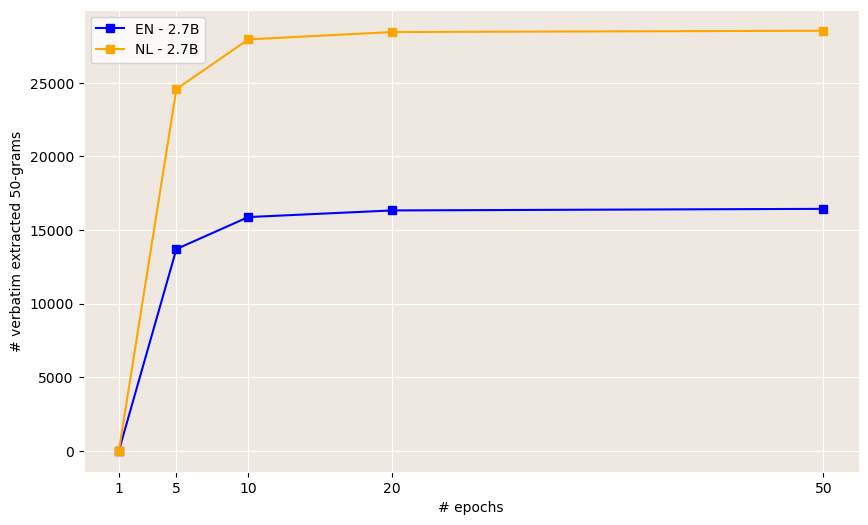

In [445]:

base = os.path.join(ROOT_DIR, DATASET_DIR)
languages = ["en", "nl"]
context = [1, 5, 10, 20, 50]
model_sizes = ["2.7B"]

# Initialize a dictionary to hold scores for each model size
scores = {lang: {size: {e: 0 for e in context} for size in model_sizes} for lang in languages}

# Collect scores
for lang in languages:
    for size in model_sizes:
        for e in context:
            acc_file = os.path.join(ROOT_DIR, DATASET_DIR, lang, f"{lang}-100-100-{size}-E{e}", "accuracy2.jsonl")
            with open(acc_file, 'r') as file:
                data = json.loads(file.readline())
                scores[lang][size][e] = data['num_exact_match']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each language
colors = {'en': 'blue', 'nl': 'orange'}
markers = ['s', 'D']  # Keep the markers if you want to differentiate model sizes visually

for lang in languages:
    for size_index, size in enumerate(model_sizes):
        corrects = [scores[lang][size][e] for e in context]
        label = f'{lang.upper()} - {size}'
        color = colors[lang]  # Select color based on language
        marker = markers[size_index % len(markers)]  # Select marker based on model size index
        ax.plot(context, corrects, label=label, color=color, marker=marker, linestyle='-')

ax.set_xlabel('# epochs')
ax.set_ylabel('# verbatim extracted 50-grams')
ax.legend()
plt.grid(True, color='white')
ax.set_facecolor('#efe8e1')
ax.set_xticks(context)
ax.set_xticklabels([str(e) for e in context])
for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.show()

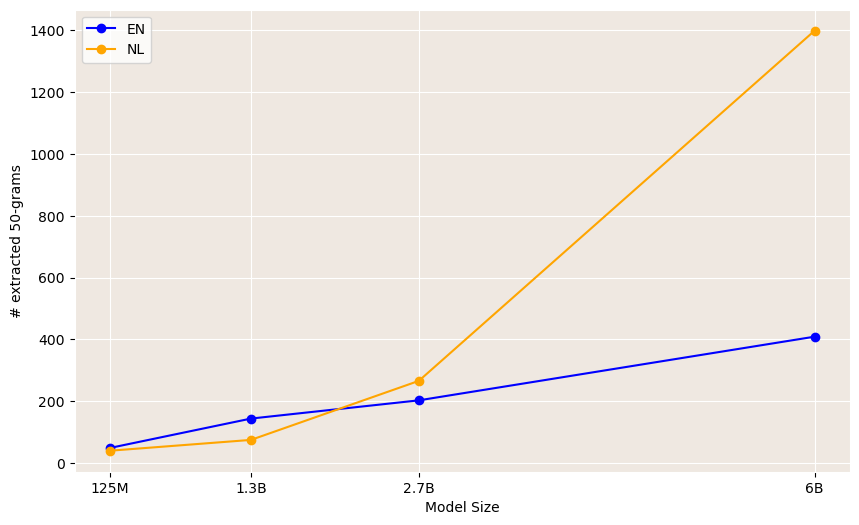

In [262]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

DATASET_DIR = "europarl"
# Assuming ROOT_DIR, DATASET_DIR, EXAMPLE_TOKEN_LEN, and NUM_TRIALS are defined
base = os.path.join(ROOT_DIR, DATASET_DIR)
model_sizes = ["125M", "1.3B", "2.7B", "6B"]
model_sizes_numeric = [125, 1300, 2700, 6000]  # Convert model sizes to a numeric scale for interpolation
languages = ["en", "nl"]

# Initialize a dictionary to hold scores
scores = {lang: {size: 0 for size in model_sizes} for lang in languages}

# Collect scores
for lang in languages:
    for size in model_sizes:
        # for europarl analysis we use accuracy2.jsonl
        acc_file = os.path.join(ROOT_DIR, DATASET_DIR, lang, f"{lang}-100-100-{size}", "accuracy2.jsonl")
        # acc_file = os.path.join(ROOT_DIR, DATASET_DIR, lang, f"{lang}-100-100-{size}", "accuracy.jsonl")
        with open(acc_file, 'r') as file:
            data = json.loads(file.readline())
            # Assuming you want to aggregate or select a specific epoch's score
            scores[lang][size] = data['num_correct']  # Adjust as needed for your data structure

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each language
colors = {'en': 'blue', 'nl': 'orange'}

for lang in languages:
    # Extract scores for each model size for the current language
    corrects = [scores[lang][size] for size in model_sizes]
    ax.plot(model_sizes_numeric, corrects, label=lang.upper(), color=colors[lang], marker='o', linestyle='-')

ax.set_xlabel('Model Size')
ax.set_ylabel('# extracted 50-grams')
ax.legend()
plt.grid(True, color='white')
ax.set_facecolor('#efe8e1')
ax.set_xticks(model_sizes_numeric)
ax.set_xticklabels(model_sizes)
for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.show()

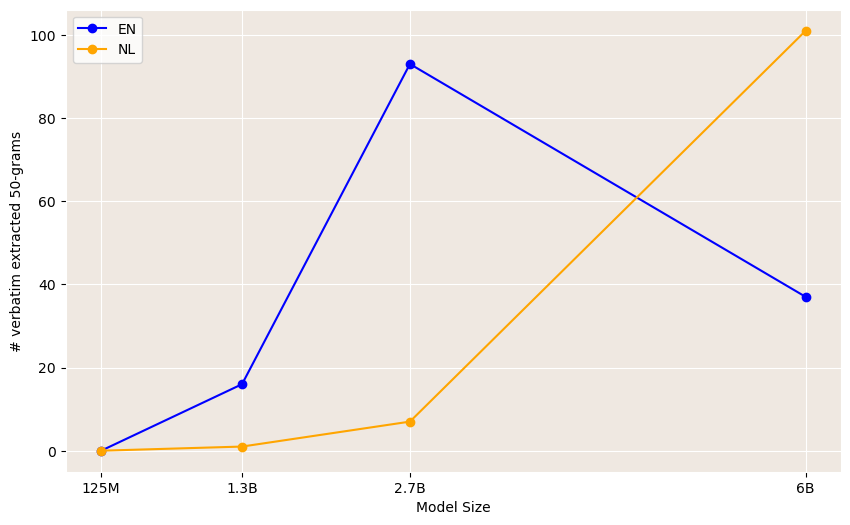

In [260]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

DATASET_DIR = "europarl"
# Assuming ROOT_DIR, DATASET_DIR, EXAMPLE_TOKEN_LEN, and NUM_TRIALS are defined
base = os.path.join(ROOT_DIR, DATASET_DIR)
model_sizes = ["125M", "1.3B", "2.7B", "6B"]
model_sizes_numeric = [125, 1300, 2700, 6000]  # Convert model sizes to a numeric scale for interpolation
languages = ["en", "nl"]

# Initialize a dictionary to hold scores
scores = {lang: {size: 0 for size in model_sizes} for lang in languages}

# Collect scores
for lang in languages:
    for size in model_sizes:
        acc_file = os.path.join(ROOT_DIR, DATASET_DIR, lang, f"{lang}-100-100-{size}", "accuracy2.jsonl")
        with open(acc_file, 'r') as file:
            data = json.loads(file.readline())
            # Assuming you want to aggregate or select a specific epoch's score
            scores[lang][size] = data['num_exact_match']  # Adjust as needed for your data structure

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each language
colors = {'en': 'blue', 'nl': 'orange'}

for lang in languages:
    # Extract scores for each model size for the current language
    corrects = [scores[lang][size] for size in model_sizes]
    ax.plot(model_sizes_numeric, corrects, label=lang.upper(), color=colors[lang], marker='o', linestyle='-')

ax.set_xlabel('Model Size')
ax.set_ylabel('# verbatim extracted 50-grams')
ax.legend()
plt.grid(True, color='white')
ax.set_facecolor('#efe8e1')
ax.set_xticks(model_sizes_numeric)
ax.set_xticklabels(model_sizes)
for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.show()

In [331]:
import os
import json

def get_losses_of_correct_guesses(exp_name: str, language: str):
    acc_path = os.path.join(f"tmp/EMEA/{language}", exp_name, "accuracy.jsonl")
    losses_base = os.path.join(f"tmp/EMEA/{language}", exp_name, "losses/decoded")

    losses_file_pattern = os.path.join(losses_base, "complete_losses.jsonl")

    # Load all loss data into a dictionary
    loss_dict = {}
    with open(losses_file_pattern, 'r') as loss_file:
        for loss_line in loss_file:
            loss_data = json.loads(loss_line)
            loss_dict[loss_data['exid']] = loss_data["losses"]

    # output = "exact_match_guess_losses.jsonl"
    output = "correct_guess_losses.jsonl"

    with open(acc_path, 'r') as file, open(os.path.join(f"tmp/EMEA/{language}", exp_name, output), 'w') as out_file:
        print(f"Reading accuracy file: {acc_path}")
        lines = file.readlines()
        # Load the first line
        data = json.loads(lines[0])

        # Get the number of correct guesses
        correct = data['num_correct']
        exact = data['num_exact_match']
        print(f"Number of correct guesses: {correct}")
        print(f"Number of exact matches: {exact}")

        # loop over all correct guesses to lookup their loss scores in the dict
        for line in lines[1:]:
            data = json.loads(line)
            exid = data['exid']
            corr = data['trials_correct']
            exac = data['trials_exact']

            # set to correct or exact match depending on the file you want
            iter = corr

            losses = []
            if exid in loss_dict.keys():
                for trial in iter:
                    # get trial number of a correct guess for lookup in the dict
                    trial_num = trial['trial']
                    loss = loss_dict[exid][trial_num]['loss']
                    losses.append({
                            "trial": trial_num,
                            "loss": loss
                        })
            else:
                print(f"exid {exid} not found in loss_dict")
                
            out_file.write(json.dumps({
                    "exid": exid,
                    "losses": losses
            }) + "\n")

In [332]:
get_losses_of_correct_guesses("nl-100-100-125M", "nl")
get_losses_of_correct_guesses("nl-100-100-1.3B", "nl")
get_losses_of_correct_guesses("nl-100-100-2.7B", "nl")

get_losses_of_correct_guesses("nl-150-100-125M", "nl")
get_losses_of_correct_guesses("nl-150-100-1.3B", "nl")
get_losses_of_correct_guesses("nl-150-100-2.7B", "nl")

get_losses_of_correct_guesses("nl-200-100-125M", "nl")
get_losses_of_correct_guesses("nl-200-100-1.3B", "nl")
get_losses_of_correct_guesses("nl-200-100-2.7B", "nl")

get_losses_of_correct_guesses("nl-250-100-125M", "nl")
get_losses_of_correct_guesses("nl-250-100-1.3B", "nl")
get_losses_of_correct_guesses("nl-250-100-2.7B", "nl")

get_losses_of_correct_guesses("en-100-100-125M", "en")
get_losses_of_correct_guesses("en-100-100-1.3B", "en")
get_losses_of_correct_guesses("en-100-100-2.7B", "en")

get_losses_of_correct_guesses("en-150-100-125M", "en")
get_losses_of_correct_guesses("en-150-100-1.3B", "en")
get_losses_of_correct_guesses("en-150-100-2.7B", "en")

get_losses_of_correct_guesses("en-200-100-125M", "en")
get_losses_of_correct_guesses("en-200-100-1.3B", "en")
get_losses_of_correct_guesses("en-200-100-2.7B", "en")

get_losses_of_correct_guesses("en-250-100-125M", "en")
get_losses_of_correct_guesses("en-250-100-1.3B", "en")
get_losses_of_correct_guesses("en-250-100-2.7B", "en")



Reading accuracy file: tmp/EMEA/nl/nl-100-100-125M/accuracy.jsonl
Number of correct guesses: 3808
Number of exact matches: 1141
Reading accuracy file: tmp/EMEA/nl/nl-100-100-1.3B/accuracy.jsonl
Number of correct guesses: 6706
Number of exact matches: 2011
Reading accuracy file: tmp/EMEA/nl/nl-100-100-2.7B/accuracy.jsonl
Number of correct guesses: 7373
Number of exact matches: 2200
Reading accuracy file: tmp/EMEA/nl/nl-150-100-125M/accuracy.jsonl
Number of correct guesses: 1804
Number of exact matches: 343
Reading accuracy file: tmp/EMEA/nl/nl-150-100-1.3B/accuracy.jsonl
Number of correct guesses: 3996
Number of exact matches: 650
Reading accuracy file: tmp/EMEA/nl/nl-150-100-2.7B/accuracy.jsonl
Number of correct guesses: 4788
Number of exact matches: 725
Reading accuracy file: tmp/EMEA/nl/nl-200-100-125M/accuracy.jsonl
Number of correct guesses: 2157
Number of exact matches: 603
Reading accuracy file: tmp/EMEA/nl/nl-200-100-1.3B/accuracy.jsonl
Number of correct guesses: 5050
Number of 

{'exid': 2121, 'num_correct': 78, 'num_exact_match': 0, 'trials_correct': [{'trial': 1, 'score': 0.958740481558872}, {'trial': 2, 'score': 0.958740481558872}, {'trial': 5, 'score': 0.958740481558872}, {'trial': 8, 'score': 0.958740481558872}, {'trial': 9, 'score': 0.958740481558872}, {'trial': 10, 'score': 0.958740481558872}, {'trial': 11, 'score': 0.958740481558872}, {'trial': 12, 'score': 0.958740481558872}, {'trial': 15, 'score': 0.958740481558872}, {'trial': 16, 'score': 0.958740481558872}, {'trial': 18, 'score': 0.958740481558872}, {'trial': 19, 'score': 0.958740481558872}, {'trial': 20, 'score': 0.958740481558872}, {'trial': 21, 'score': 0.958740481558872}, {'trial': 22, 'score': 0.958740481558872}, {'trial': 23, 'score': 0.958740481558872}, {'trial': 24, 'score': 0.958740481558872}, {'trial': 25, 'score': 0.958740481558872}, {'trial': 26, 'score': 0.958740481558872}, {'trial': 27, 'score': 0.958740481558872}, {'trial': 28, 'score': 0.958740481558872}, {'trial': 29, 'score': 0.95

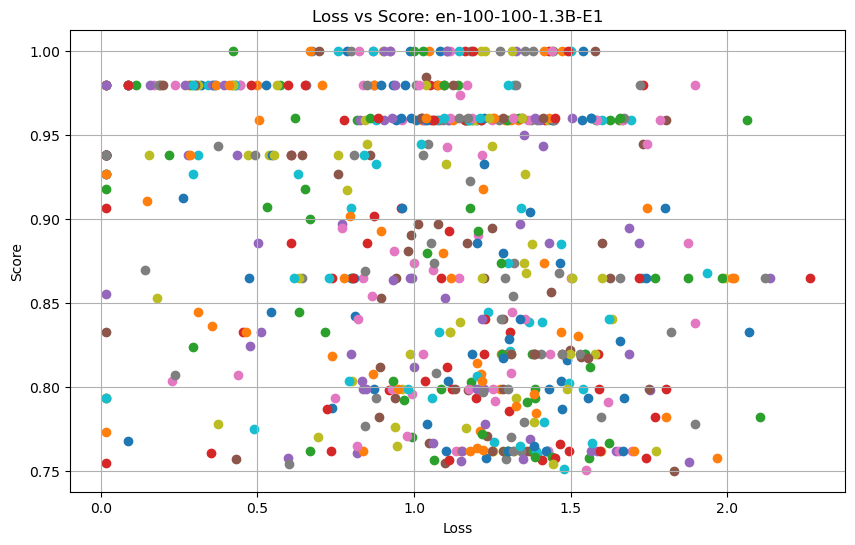

In [144]:
import json
import matplotlib.pyplot as plt

exp_name = "en-100-100-1.3B-E1"

lang = "en"

# Filepaths to your JSONL files
filepath_losses = os.path.join(f"tmp/EMEA/epoch/{lang}", exp_name, "correct_guess_losses.jsonl")
filepath_scores = os.path.join(f"tmp/EMEA/epoch/{lang}", exp_name, "accuracy.jsonl")

# Initialize dictionaries to hold the data
losses_dict = {}
scores_dict = {}

# Load the data from the losses JSONL file
with open(filepath_losses, 'r') as file:
    for line in file:
        data = json.loads(line)
        for item in data['losses']:
            losses_dict[(data['exid'], item['trial'])] = item['loss']

# Load the data from the scores JSONL file
with open(filepath_scores, 'r') as file:
    lines = file.readlines()
    for line in lines[1:]:
        data = json.loads(line)
        for item in data['trials_correct']:
            scores_dict[(data['exid'], item['trial'])] = item['score']

# Create lists for plotting
exids = []
trials = []
losses = []
scores = []

for key in losses_dict.keys():
    if key in scores_dict:
        exids.append(key[0])
        trials.append(key[1])
        losses.append(losses_dict[key])
        scores.append(scores_dict[key])

# Create the plot
plt.figure(figsize=(10, 6))
for exid, trial, score, loss in zip(exids, trials, scores, losses):
    plt.scatter(loss, score, label=f'exid: {exid}')
plt.ylabel('Score')
plt.xlabel('Loss')
plt.title('Loss vs Score: ' + exp_name)
plt.grid(True)
plt.show()

In [335]:
from math import exp
import os

def avg_perplexity(exp_name, language):
    filepath_losses = os.path.join("tmp/EMEA/context/", language, exp_name, "exact_match_guess_losses.jsonl")
    # filepath_losses = os.path.join("tmp/EMEA/context/", language, exp_name, "correct_guess_losses.jsonl")

    out_file = f'tmp/EMEA/{language}/average_perplexity.jsonl'

    # load all values in file
    with open(filepath_losses, 'r') as file:
        lines = file.readlines()
        
        # load all losses in a list
        losses = []
        for line in lines:
            data = json.loads(line)
            for item in data['losses']:
                # taking average of exact matches only 
                losses.append(exp(item['loss']))

        print(f"Total number of losses for {exp_name}: {len(losses)}")

        if len(losses) == 0:
            avg = 0
        else:
            avg = sum(losses) / len(losses)

        print(f"Average perplexity: {avg}")

    with open(out_file, 'a') as file:
        file.write(json.dumps({"experiment_name": exp_name,
                            "average_perplexity_EM": avg}) + "\n")

In [336]:
avg_perplexity("nl-100-100-125M", "nl")
avg_perplexity("nl-100-100-1.3B", "nl")
avg_perplexity("nl-100-100-2.7B", "nl")

avg_perplexity("nl-150-100-125M", "nl")
avg_perplexity("nl-150-100-1.3B", "nl")
avg_perplexity("nl-150-100-2.7B", "nl")

avg_perplexity("nl-200-100-125M", "nl")
avg_perplexity("nl-200-100-1.3B", "nl")
avg_perplexity("nl-200-100-2.7B", "nl")

avg_perplexity("nl-250-100-125M", "nl")
avg_perplexity("nl-250-100-1.3B", "nl")
avg_perplexity("nl-250-100-2.7B", "nl")

avg_perplexity("en-100-100-125M", "en")
avg_perplexity("en-100-100-1.3B", "en")
avg_perplexity("en-100-100-2.7B", "en")

avg_perplexity("en-150-100-125M", "en")
avg_perplexity("en-150-100-1.3B", "en")
avg_perplexity("en-150-100-2.7B", "en")

avg_perplexity("en-200-100-125M", "en")
avg_perplexity("en-200-100-1.3B", "en")
avg_perplexity("en-200-100-2.7B", "en")

avg_perplexity("en-250-100-125M", "en")
avg_perplexity("en-250-100-1.3B", "en")
avg_perplexity("en-250-100-2.7B", "en")

Total number of losses for nl-100-100-125M: 1141
Average perplexity: 4.01354027385668
Total number of losses for nl-100-100-1.3B: 2011
Average perplexity: 2.796736755208157
Total number of losses for nl-100-100-2.7B: 2200
Average perplexity: 2.6518066114739813
Total number of losses for nl-150-100-125M: 343
Average perplexity: 4.131121865438514
Total number of losses for nl-150-100-1.3B: 650
Average perplexity: 2.682026587190735
Total number of losses for nl-150-100-2.7B: 725
Average perplexity: 2.6593410914588014
Total number of losses for nl-200-100-125M: 603
Average perplexity: 4.081828558281317
Total number of losses for nl-200-100-1.3B: 1267
Average perplexity: 2.745284906875857
Total number of losses for nl-200-100-2.7B: 1395
Average perplexity: 2.6333331994171134
Total number of losses for nl-250-100-125M: 577
Average perplexity: 3.7493550331422845
Total number of losses for nl-250-100-1.3B: 1411
Average perplexity: 2.635816154975586
Total number of losses for nl-250-100-2.7B: 2

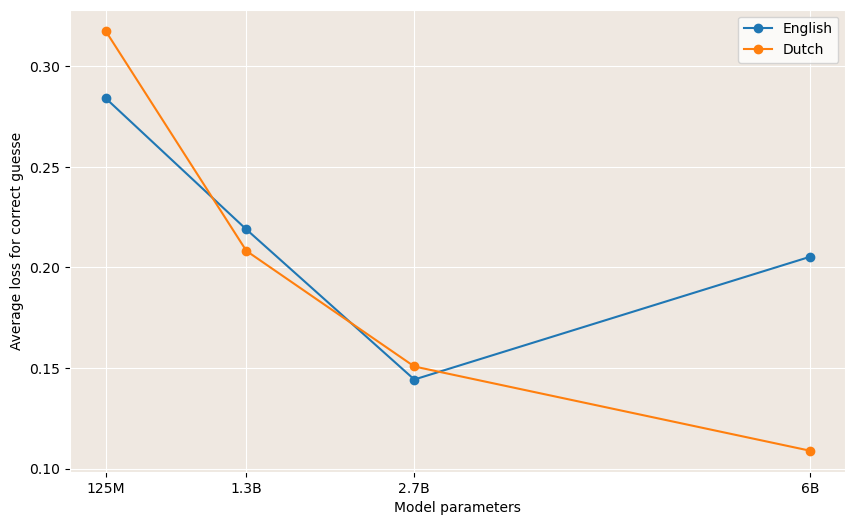

In [48]:
import json
import matplotlib.pyplot as plt
def plot_average_loss(file1, file2):
    # Load the data from the JSONL file
    data1 = []
    with open(file1, 'r') as file:
        for line in file:
            data1.append(json.loads(line))

    data2 = []
    with open(file2, 'r') as file:
        for line in file:
            data2.append(json.loads(line))

    # Extract the model sizes and average losses
    # add 6B here
    model_sizes = [125000000, 1300000000, 2700000000, 6000000000]

    average_losses_en = []
    average_losses_nl = []
    for data in data1:
        average_losses_en.append(data['average_loss'])

    for data in data2:
         average_losses_nl.append(data['average_loss'])      

    # Create the plot
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(model_sizes, average_losses_en, 'o-', label='English')
    ax.plot(model_sizes, average_losses_nl, 'o-', label='Dutch')
    ax.set_ylabel('Average loss for correct guesse')
    ax.set_xlabel('Model parameters')
    # ax.set_title('Average Loss vs Model Size')
    ax.legend()
    plt.grid(True, color='white')  # Set the grid line color
    ax.set_facecolor('#efe8e1')  # Set the background color
    ax.set_xticks(model_sizes)
    ax.set_xticklabels(['125M', '1.3B', '2.7B', '6B'])

    # Set the color of the spines to white
    for spine in ax.spines.values():
        spine.set_edgecolor('white')


    # save figure
    plt.savefig('tmp/europarl/average_loss.png')

    plt.show()




nl = "tmp/europarl/nl/average_loss.jsonl"
en = "tmp/europarl/en/average_loss.jsonl"

plot_average_loss(en, nl)

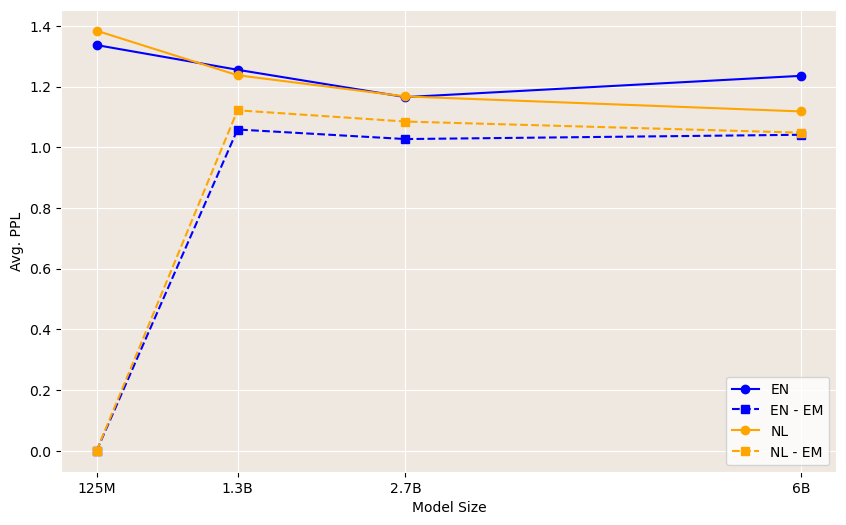

In [198]:
import json
import matplotlib.pyplot as plt

def plot_perplexities(file1, file2):

    # Initialize lists to hold the perplexities
    avg_perplexities_en = []
    avg_perplexities_en_em = []
    avg_perplexities_nl = []
    avg_perplexities_nl_em = []


    # Load the data from the JSONL files
    data1 = []

    # assumption: file 1 is English and file 2 is Dutch
    with open(file1, 'r') as file:
        for line in file:  # only read the first two lines
            data = json.loads(line)
            if data.get('average_perplexity') is not None:
                avg_perplexities_en.append(data['average_perplexity'])
            else:
                avg_perplexities_en_em.append(data['average_perplexity_EM'])

    data2 = []
    with open(file2, 'r') as file:
        for line in file:
            data = json.loads(line)
            if data.get('average_perplexity') is not None:
                avg_perplexities_nl.append(data['average_perplexity'])
            else:
                avg_perplexities_nl_em.append(data['average_perplexity_EM'])

    # Extract the model sizes
    model_sizes = [125000000, 1300000000, 2700000000, 6000000000]

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(model_sizes, avg_perplexities_en, 'o-', color='blue', label='EN')
    ax.plot(model_sizes, avg_perplexities_en_em, 's--', color='blue', label='EN - EM')
    ax.plot(model_sizes, avg_perplexities_nl, 'o-', color='orange', label='NL')
    ax.plot(model_sizes, avg_perplexities_nl_em, 's--', color='orange', label='NL - EM')

    ax.set_ylabel("Avg. PPL")
    ax.set_xlabel('Model Size')
    ax.legend()
    plt.grid(True, color='white')
    ax.set_facecolor('#efe8e1')
    ax.set_xticks(model_sizes)
    ax.set_xticklabels(['125M', '1.3B', '2.7B', '6B'])

    for spine in ax.spines.values():
        spine.set_edgecolor('white')

    # Save and show the figure
    plt.savefig('tmp/europarl/perplexity_comparison.png')
    plt.show()

# File paths
nl = "tmp/europarl/nl/average_perplexity.jsonl"
en = "tmp/europarl/en/average_perplexity.jsonl"

# Call the function
plot_perplexities(en, nl)

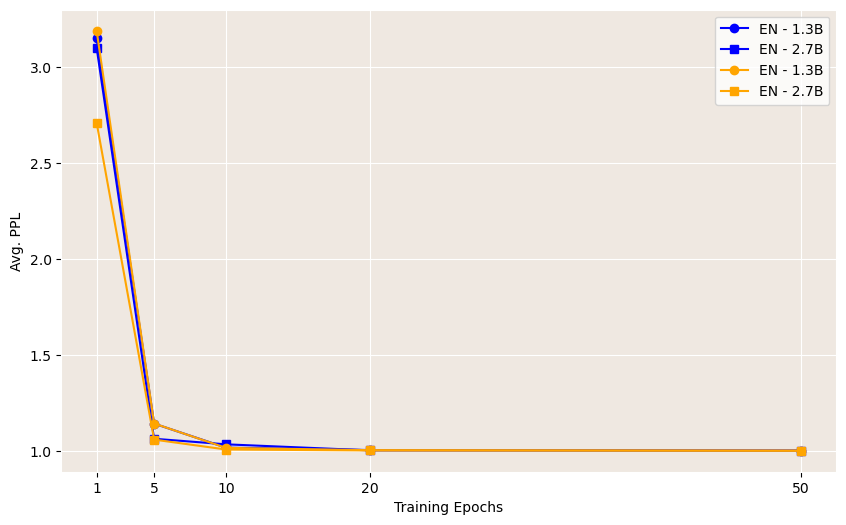

In [245]:
import json
import matplotlib.pyplot as plt

def plot_perplexities(file1, file2):

    epochs = [1, 5, 10, 20, 50]


    # Initialize dictionaries to hold the perplexities
    avg_perplexities_en = {
        "1.3B": [],
        "2.7B": []
    }

    avg_perplexities_nl = {
        "1.3B": [],
        "2.7B": []
    }

    avg_perplexities_EM_en = {
        "1.3B": [],
        "2.7B": []
    }

    avg_perplexities_EM_nl = {
        "1.3B": [],
        "2.7B": []
    }

    length = len(epochs) * 2

    # Load the data from the JSONL files
    with open(file1, 'r') as file:
        lines = file.readlines()
        for line in lines[:length]: 
            data = json.loads(line)
            model_size = data['experiment_name'].split('-')[3]
            avg_perplexities_en[model_size].append(data['average_perplexity'])

    with open(file2, 'r') as file:
        lines = file.readlines()
        for line in lines[:length]:
            data = json.loads(line)
            model_size = data['experiment_name'].split('-')[3]
            avg_perplexities_nl[model_size].append(data['average_perplexity'])


    # Load the data from the JSONL files
    with open(file1, 'r') as file:
        lines = file.readlines()
        for line in lines[length:]: 
            data = json.loads(line)
            model_size = data['experiment_name'].split('-')[3]
            avg_perplexities_EM_en[model_size].append(data['average_perplexity_EM'])

    with open(file2, 'r') as file:
        lines = file.readlines()
        for line in lines[length:]:
            data = json.loads(line)
            model_size = data['experiment_name'].split('-')[3]
            avg_perplexities_EM_nl[model_size].append(data['average_perplexity_EM'])

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(epochs, avg_perplexities_en["1.3B"], 'o-', color='blue', label='EN - 1.3B')
    ax.plot(epochs, avg_perplexities_en["2.7B"], 's-', color='blue', label='EN - 2.7B')
    ax.plot(epochs, avg_perplexities_nl["1.3B"], 'o-', color='orange', label='EN - 1.3B')
    ax.plot(epochs, avg_perplexities_nl["2.7B"], 's-', color='orange', label='EN - 2.7B')

    # ax.plot(epochs, avg_perplexities_EM_en["1.3B"], 'o--', color='blue', label='EN - 1.3B - EM')
    # ax.plot(epochs, avg_perplexities_EM_en["2.7B"], 's--', color='blue', label='EN - 2.7B - EM')
    # ax.plot(epochs, avg_perplexities_EM_nl["1.3B"], 'o--', color='orange', label='EN - 1.3B - EM')
    # ax.plot(epochs, avg_perplexities_EM_nl["2.7B"], 's--', color='orange', label='EN - 2.7B - EM')

    ax.set_ylabel("Avg. PPL")
    ax.set_xlabel('Training Epochs')
    ax.legend()
    plt.grid(True, color='white')
    ax.set_facecolor('#efe8e1')
    ax.set_xticks(epochs)
    ax.set_xticklabels(['1', '5', '10', '20', '50'])

    for spine in ax.spines.values():
        spine.set_edgecolor('white')

    # Save and show the figure
    plt.savefig('tmp/EMEA/epoch/perplexity_comparison.png')
    plt.show()

# File paths
nl = "tmp/EMEA/epoch/nl/average_perplexity.jsonl"
en = "tmp/EMEA/epoch/en/average_perplexity.jsonl"

# Call the function
plot_perplexities(en, nl)

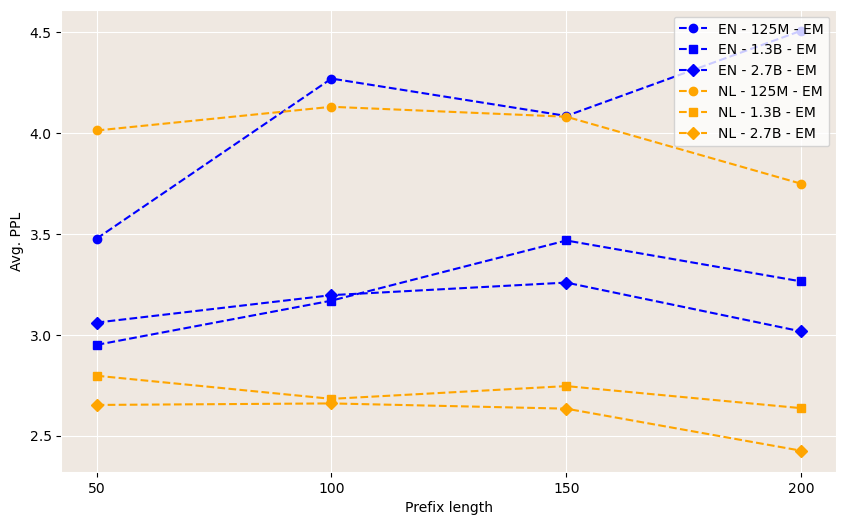

In [344]:
import json
import matplotlib.pyplot as plt

def plot_perplexities(file1, file2):
    context = [50, 100, 150, 200]

    # Initialize dictionaries to hold the perplexities
    avg_perplexities_en = {
        "125M": [],
        "1.3B": [],
        "2.7B": []
    }

    avg_perplexities_nl = {
        "125M": [],
        "1.3B": [],
        "2.7B": []
    }

    avg_perplexities_EM_en = {
        "125M": [],
        "1.3B": [],
        "2.7B": []
    }

    avg_perplexities_EM_nl = {
        "125M": [],
        "1.3B": [],
        "2.7B": []
    }

    # Load the data from the JSONL files
    with open(file1, 'r') as file:
        lines = file.readlines()
        for line in lines:
            data = json.loads(line)
            model_size = data['experiment_name'].split('-')[3]
            if 'average_perplexity' in data:
                avg_perplexities_en[model_size].append(data['average_perplexity'])
            if 'average_perplexity_EM' in data:
                avg_perplexities_EM_en[model_size].append(data['average_perplexity_EM'])

    with open(file2, 'r') as file:
        lines = file.readlines()
        for line in lines:
            data = json.loads(line)
            model_size = data['experiment_name'].split('-')[3]
            if 'average_perplexity' in data:
                avg_perplexities_nl[model_size].append(data['average_perplexity'])
            if 'average_perplexity_EM' in data:
                avg_perplexities_EM_nl[model_size].append(data['average_perplexity_EM'])

    # # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    # ax.plot(context, avg_perplexities_en["125M"], 'o-', color='blue', label='EN - 125M')
    # ax.plot(context, avg_perplexities_en["1.3B"], 's-', color='blue', label='EN - 1.3B')
    # ax.plot(context, avg_perplexities_en["2.7B"], 'D-', color='blue', label='EN - 2.7B')

    # ax.plot(context, avg_perplexities_nl["125M"], 'o-', color='orange', label='NL - 125M')
    # ax.plot(context, avg_perplexities_nl["1.3B"], 's-', color='orange', label='NL - 1.3B')
    # ax.plot(context, avg_perplexities_nl["2.7B"], 'D-', color='orange', label='NL - 2.7B')

    ax.plot(context, avg_perplexities_EM_en["125M"], 'o--', color='blue', label='EN - 125M - EM')
    ax.plot(context, avg_perplexities_EM_en["1.3B"], 's--', color='blue', label='EN - 1.3B - EM')
    ax.plot(context, avg_perplexities_EM_en["2.7B"], 'D--', color='blue', label='EN - 2.7B - EM')
    ax.plot(context, avg_perplexities_EM_nl["125M"], 'o--', color='orange', label='NL - 125M - EM')
    ax.plot(context, avg_perplexities_EM_nl["1.3B"], 's--', color='orange', label='NL - 1.3B - EM')
    ax.plot(context, avg_perplexities_EM_nl["2.7B"], 'D--', color='orange', label='NL - 2.7B - EM')

    ax.set_ylabel("Avg. PPL")
    ax.set_xlabel('Prefix length')
    ax.legend()
    plt.grid(True, color='white')
    ax.set_facecolor('#efe8e1')
    ax.set_xticks(context)
    ax.set_xticklabels(['50', '100', '150', '200'])

    for spine in ax.spines.values():
        spine.set_edgecolor('white')

    # Save and show the figure
    plt.savefig('tmp/EMEA/context/perplexity_comparison.png')
    plt.show()

# File paths
nl = "tmp/EMEA/nl/average_perplexity.jsonl"
en = "tmp/EMEA/en/average_perplexity.jsonl"

# Call the function
plot_perplexities(en, nl)

In [ ]:
from math import exp
import os

def avg_perplexity(exp_name, language):
    filepath_losses = os.path.join("tmp/EMEA/context/", language, exp_name, "exact_match_guess_losses.jsonl")
    # filepath_losses = os.path.join("tmp/EMEA/context/", language, exp_name, "correct_guess_losses.jsonl")

    out_file = f'tmp/EMEA/context/{language}/average_perplexity.jsonl'

    # load all values in file
    with open(filepath_losses, 'r') as file:
        lines = file.readlines()
        
        # load all losses in a list
        losses = []
        for line in lines:
            data = json.loads(line)
            for item in data['losses']:
                # taking average of exact matches only 
                losses.append(exp(item['loss']))

        print(f"Total number of losses for {exp_name}: {len(losses)}")

        if len(losses) == 0:
            avg = 0
        else:
            avg = sum(losses) / len(losses)

        print(f"Average perplexity: {avg}")

    with open(out_file, 'a') as file:
        file.write(json.dumps({"experiment_name": exp_name,
                            "average_perplexity_EM": avg}) + "\n")

NameError: name 'model_sizes_numeric' is not defined

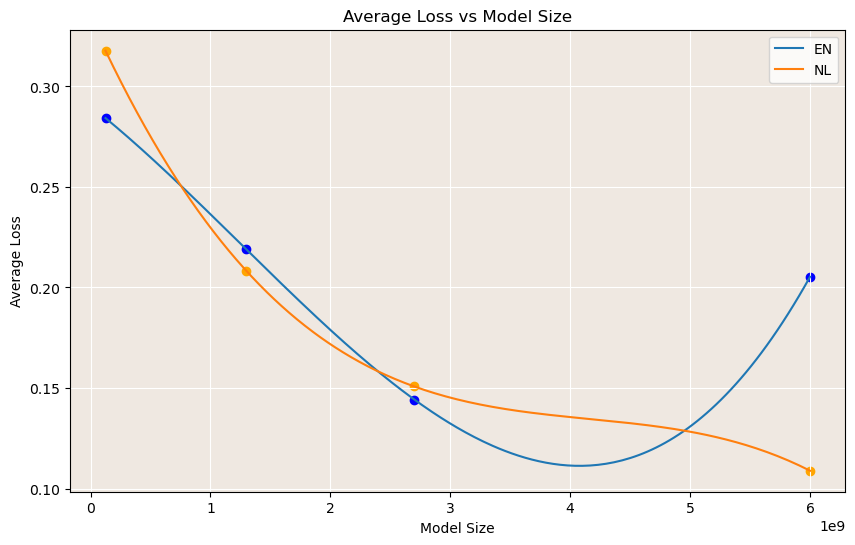

In [240]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

def plot_average_loss_interpolated(file1, file2):
    # Load the data from the JSONL file
    data1 = []
    with open(file1, 'r') as file:
        for line in file:
            data1.append(json.loads(line))

    data2 = []
    with open(file2, 'r') as file:
        for line in file:
            data2.append(json.loads(line))

    # Extract the model sizes and average losses
    model_sizes = [125000000, 1300000000, 2700000000, 6000000000]

    average_losses_en = []
    average_losses_nl = []
    for data in data1:
        average_losses_en.append(data['average_loss'])

    for data in data2:
         average_losses_nl.append(data['average_loss'])

    # Create the cubic spline interpolation functions
    cs_en = CubicSpline(model_sizes, average_losses_en)
    cs_nl = CubicSpline(model_sizes, average_losses_nl)

    # Create an array of x values for the interpolated function
    xs = np.logspace(np.log10(min(model_sizes)), np.log10(max(model_sizes)), 500)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(xs, cs_en(xs), label='EN')
    ax.plot(xs, cs_nl(xs), label='NL')
    ax.scatter(model_sizes, average_losses_en, color='blue')
    ax.scatter(model_sizes, average_losses_nl, color='orange')
    ax.set_ylabel('Average Loss')
    ax.set_xlabel('Model Size')
    ax.set_title('Average Loss vs Model Size')
    ax.legend()
    plt.grid(True, color='white')
    ax.set_facecolor('#efe8e1')
    ax.set_xticks(model_sizes_numeric)
    ax.set_xticklabels(['125M', '1.3B', '2.7B', '6B'])

    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        
    plt.show()

nl = "tmp/europarl/nl/average_loss.jsonl"
en = "tmp/europarl/en/average_loss.jsonl"

plot_average_loss_interpolated(en, nl)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (3).

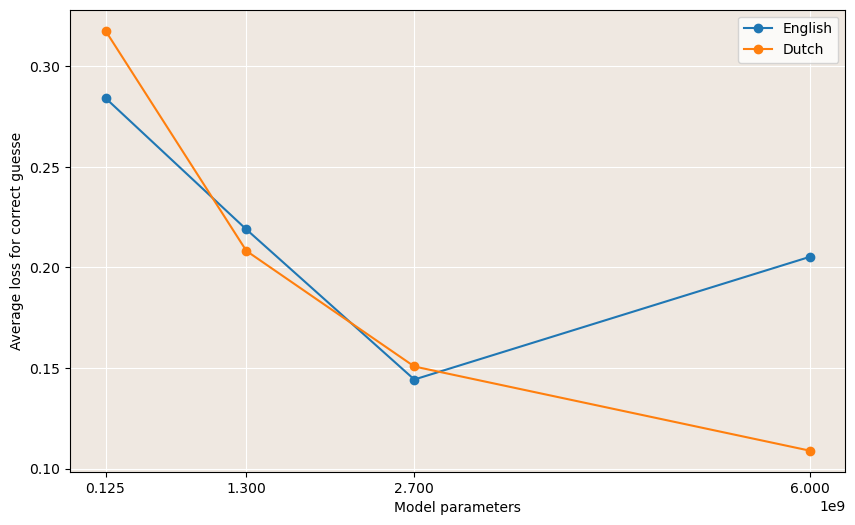

In [52]:
import json
import matplotlib.pyplot as plt
def plot_average_loss(file1, file2):
    # Load the data from the JSONL file
    data1 = []
    with open(file1, 'r') as file:
        for line in file:
            data1.append(json.loads(line))

    data2 = []
    with open(file2, 'r') as file:
        for line in file:
            data2.append(json.loads(line))

    # Extract the model sizes and average losses
    # add 6B here
    model_sizes = [125000000, 1300000000, 2700000000, 6000000000]

    average_losses_en = []
    average_losses_nl = []
    for data in data1:
        average_losses_en.append(data['average_loss'])

    for data in data2:
         average_losses_nl.append(data['average_loss'])      

    # Create the plot
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(model_sizes, average_losses_en, 'o-', label='English')
    ax.plot(model_sizes, average_losses_nl, 'o-', label='Dutch')
    ax.set_ylabel('Average loss for correct guesse')
    ax.set_xlabel('Model parameters')
    # ax.set_title('Average Loss vs Model Size')
    ax.legend()
    plt.grid(True, color='white')  # Set the grid line color
    ax.set_facecolor('#efe8e1')  # Set the background color
    ax.set_xticks(model_sizes)
    ax.set_xticklabels(['125M', '1.3B', '2.7B, 6B'])

    # Set the color of the spines to white
    for spine in ax.spines.values():
        spine.set_edgecolor('white')


    # save figure
    plt.savefig('tmp/europarl/average_loss.png')

    plt.show()




nl = "tmp/europarl/nl/average_loss.jsonl"
en = "tmp/europarl/en/average_loss.jsonl"

plot_average_loss(en, nl)

In [32]:
import json
import pandas as pd
import matplotlib.pyplot as plt

scores = "tmp/europarl/nl/nl-100-100-2.7B/bleu_scores/sorted_compl_bleu_scores.jsonl"
losses = "tmp/europarl/nl/nl-100-100-2.7B/losses/decoded/sorted_compl_losses.jsonl"
# Load the data
with open(scores, 'r') as f:
    scores_data = [json.loads(line) for line in f]
with open(losses, 'r') as f:
    losses_data = [json.loads(line) for line in f]

# Convert to pandas DataFrame
scores_df = pd.json_normalize(scores_data, 'scores', ['exid'])
losses_df = pd.json_normalize(losses_data, 'losses', ['exid'])

# Merge the two DataFrames
merged_df = pd.merge(scores_df, losses_df, on=['exid', 'trial'])

# Plot the data
plt.scatter(merged_df['loss'], merged_df['score'], s=1, marker='x', alpha=0.1)
plt.axhline(y=0.75, color='r', linestyle='--')
plt.xlabel('Loss')
plt.ylabel('Score')
plt.show()

KeyboardInterrupt: 

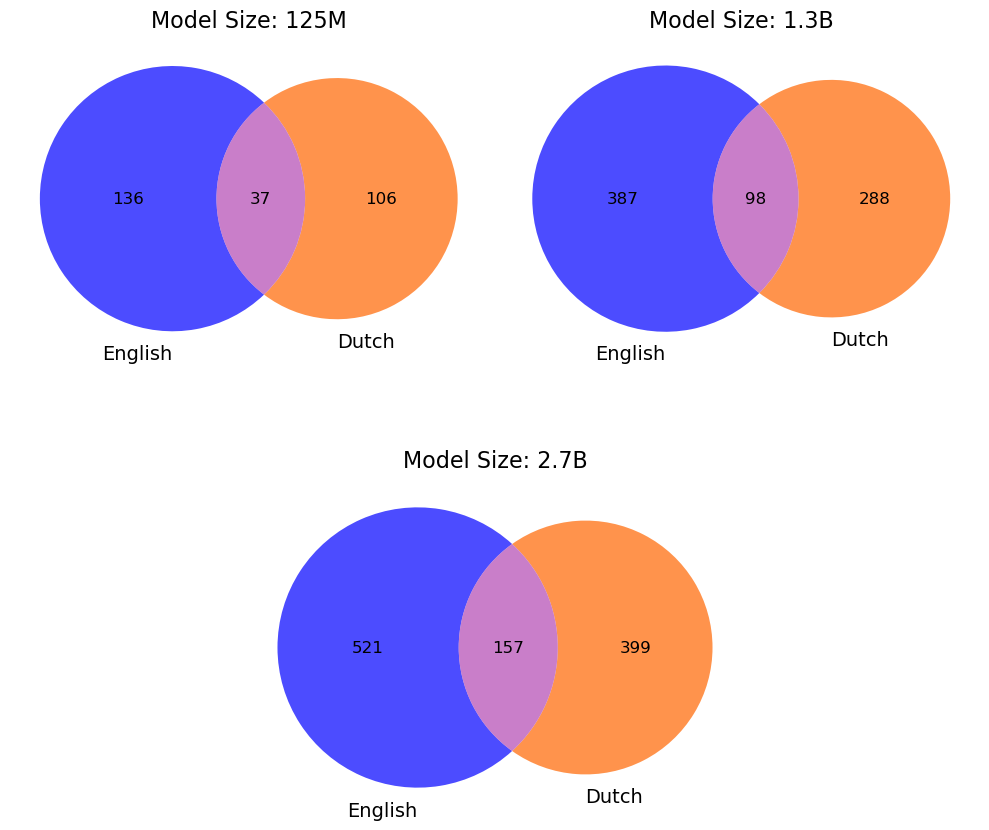

In [387]:
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
import json
import matplotlib.gridspec as gridspec

model_sizes = ["125M", "1.3B", "2.7B", "6B"]

def load_unique_exids(path):
    exids = []
    with open(path, "r") as in_nl:
        next(in_nl)  # Skip the first line
        for line in in_nl:
            exids.append(int(json.loads(line)["exid"]))
    return exids

plt.figure(figsize=(10, 10))

# Create a GridSpec with 2 rows and 2 columns
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.5])  # Adjust the height ratio of the rows

# Top row positions
positions = [(0, 0), (0, 1)]

# Loop through the top row positions
for i, (row, col) in enumerate(positions):
    acc_nl = f"tmp/emea/nl/nl-250-100-{model_sizes[i]}/accuracy.jsonl"
    acc_en = f"tmp/emea/en/en-250-100-{model_sizes[i]}/accuracy.jsonl"

    nl_exids = load_unique_exids(acc_nl)
    en_exids = load_unique_exids(acc_en)

    common_exids = list(set(nl_exids) & set(en_exids))

    ax = plt.subplot(gs[row, col])
    v = venn2(
        subsets=(len(en_exids), len(nl_exids), len(common_exids)),
        set_labels=("English", "Dutch"),
        set_colors=((0, 0, 1), (1, 0.4, 0)),
        alpha=0.7,
    )
    
    # Increase label sizes
    for text in v.set_labels:
        if text:  # Check if the label is not None
            text.set_fontsize(14)  # Adjust the size as needed
    for text in v.subset_labels:
        if text:  # Check if the label is not None
            text.set_fontsize(12)  # Adjust the size as needed

    ax.set_title(f"Model Size: {model_sizes[i]}", fontsize=16)  # Increase title size

# Position for the third Venn diagram in the bottom middle
acc_nl = f"tmp/emea/nl/nl-250-100-{model_sizes[2]}/accuracy.jsonl"
acc_en = f"tmp/emea/en/en-250-100-{model_sizes[2]}/accuracy.jsonl"

nl_exids = load_unique_exids(acc_nl)
en_exids = load_unique_exids(acc_en)

common_exids = list(set(nl_exids) & set(en_exids))

ax = plt.subplot(gs[1, :])
v = venn2(
    subsets=(len(en_exids), len(nl_exids), len(common_exids)),
    set_labels=("English", "Dutch"),
    set_colors=((0, 0, 1), (1, 0.4, 0)),
    alpha=0.7,
)

# Increase label sizes
for text in v.set_labels:
    if text:  # Check if the label is not None
        text.set_fontsize(14)  # Adjust the size as needed
for text in v.subset_labels:
    if text:  # Check if the label is not None
        text.set_fontsize(12)  # Adjust the size as needed

ax.set_title(f"Model Size: {model_sizes[2]}", fontsize=16)  # Increase title size

plt.tight_layout()
plt.show()
 

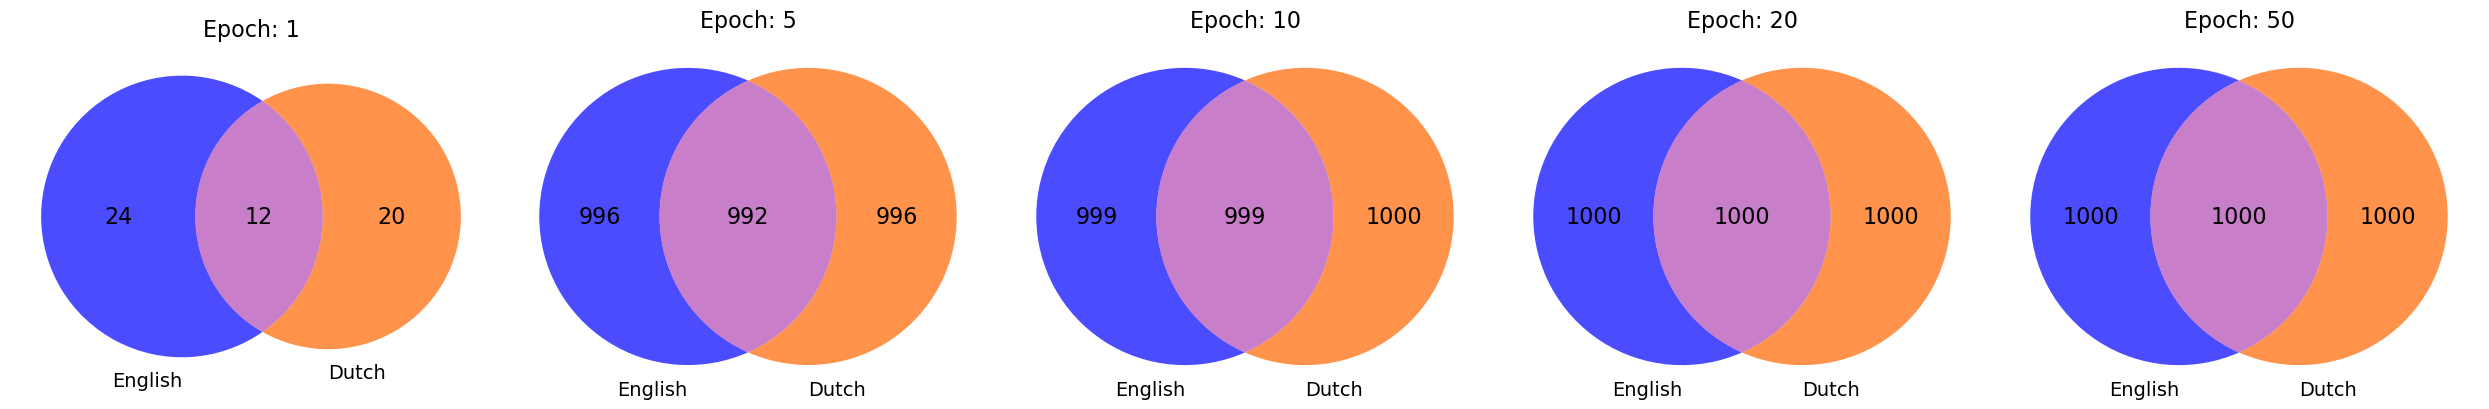

In [437]:
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
import json
import matplotlib.gridspec as gridspec

model_size = "2.7B"
epochs = [1, 5, 10, 20, 50]

def load_unique_exids(path):
    exids = []
    with open(path, "r") as in_nl:
        next(in_nl)  # Skip the first line
        for line in in_nl:
            exids.append(int(json.loads(line)["exid"]))
    return exids

plt.figure(figsize=(25, 5))  # Adjust the figure size to accommodate the new layout

# Create a GridSpec with 1 row and 5 columns
gs = gridspec.GridSpec(1, 5)

# Loop through the epochs and create a Venn diagram for each
for i, epoch in enumerate(epochs):
    acc_nl = f"tmp/EMEA/epoch/nl/nl-100-100-{model_size}-E{epoch}/accuracy.jsonl"
    acc_en = f"tmp/EMEA/epoch/en/en-100-100-{model_size}-E{epoch}/accuracy.jsonl"

    nl_exids = load_unique_exids(acc_nl)
    en_exids = load_unique_exids(acc_en)

    common_exids = list(set(nl_exids) & set(en_exids))

    row, col = 0, i

    ax = plt.subplot(gs[row, col])
    v = venn2(
        subsets=(len(en_exids), len(nl_exids), len(common_exids)),
        set_labels=("English", "Dutch"),
        set_colors=((0, 0, 1), (1, 0.4, 0)),
        alpha=0.7,
    )
    
    # Increase label sizes
    for text in v.set_labels:
        if text:  # Check if the label is not None
            text.set_fontsize(14)  # Adjust the size as needed
    for text in v.subset_labels:
        if text:  # Check if the label is not None
            text.set_fontsize(16)  # Adjust the size as needed

    ax.set_title(f"Epoch: {epoch}", fontsize=16)  # Increase title size

plt.tight_layout()
plt.show()

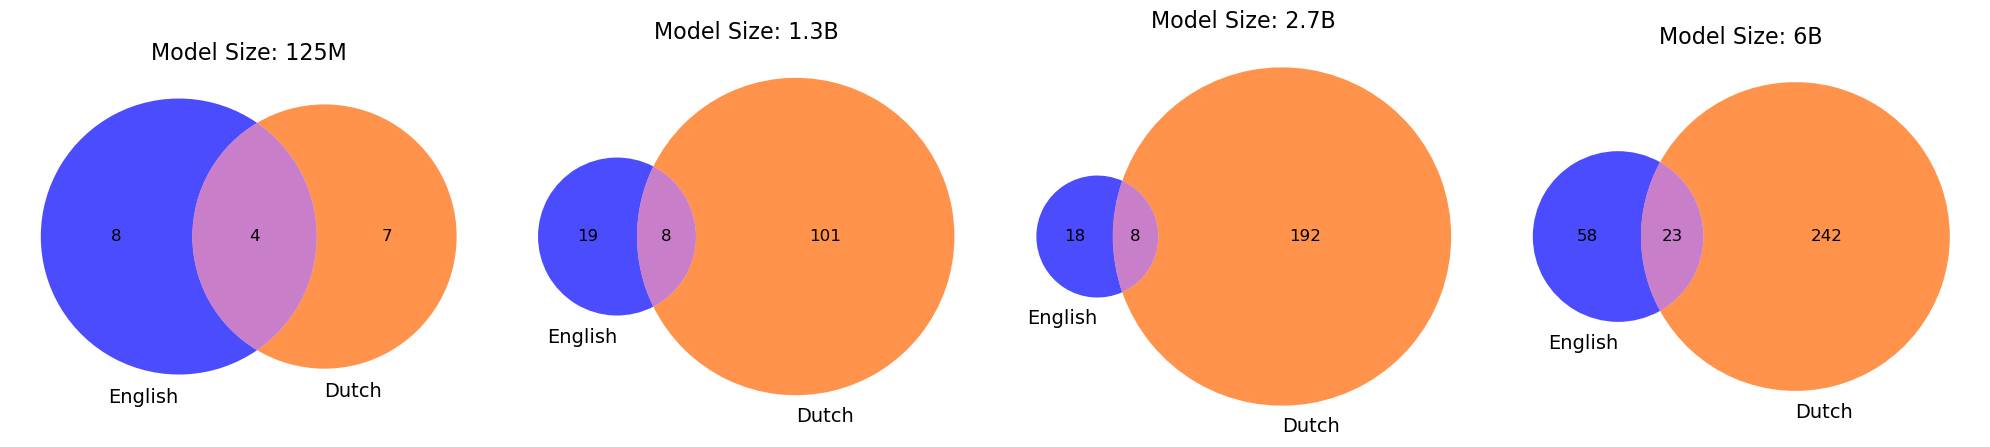

In [258]:
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
import json
import matplotlib.gridspec as gridspec

model_sizes = ["125M", "1.3B", "2.7B", "6B"]

def load_unique_exids(path):
    exids = []
    with open(path, "r") as in_nl:
        next(in_nl)  # Skip the first line
        for line in in_nl:
            exids.append(int(json.loads(line)["exid"]))
    return exids

plt.figure(figsize=(20, 5))  # Adjust the figure size to accommodate four plots in one row

# Create a GridSpec with 1 row and 4 columns
gs = gridspec.GridSpec(1, 4)

# Loop through the positions
for i in range(4):
    acc_nl = f"tmp/europarl/nl/nl-100-100-{model_sizes[i]}/accuracy.jsonl"
    acc_en = f"tmp/europarl/en/en-100-100-{model_sizes[i]}/accuracy.jsonl"

    nl_exids = load_unique_exids(acc_nl)
    en_exids = load_unique_exids(acc_en)

    common_exids = list(set(nl_exids) & set(en_exids))

    ax = plt.subplot(gs[0, i])
    v = venn2(
        subsets=(len(en_exids), len(nl_exids), len(common_exids)),
        set_labels=("English", "Dutch"),
        set_colors=((0, 0, 1), (1, 0.4, 0)),
        alpha=0.7,
    )
    
    # Increase label sizes
    for text in v.set_labels:
        if text:  # Check if the label is not None
            text.set_fontsize(14)  # Adjust the size as needed
    for text in v.subset_labels:
        if text:  # Check if the label is not None
            text.set_fontsize(12)  # Adjust the size as needed

    ax.set_title(f"Model Size: {model_sizes[i]}", fontsize=16)  # Increase title size

plt.tight_layout()
plt.show()

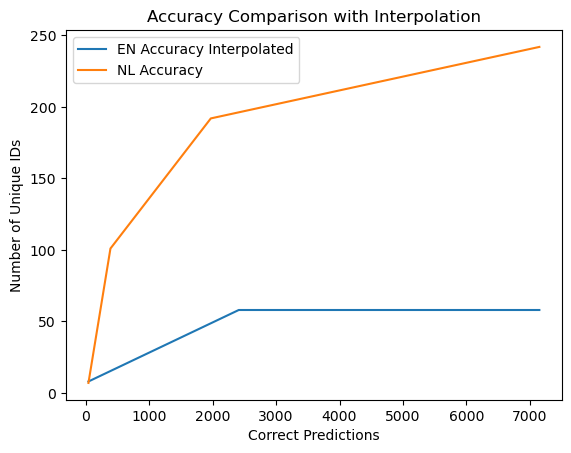

In [67]:
# number of extracted vs unique extracted

from matplotlib import pyplot as plt
import json

model_sizes = ["125M", "1.3B", "2.7B", "6B"]

x_nl = []
x_en = []

y_nl = []
y_en = []


def load_unique_exids(path):
    exids = []
    num_correct = None  # Initialize variable to store num_correct
    with open(path, "r") as in_nl:
        first_line = True  # Flag to check if it's the first line
        for line in in_nl:
            if first_line:
                # Extract num_correct from the first line and convert to int
                num_correct = int(json.loads(line)['num_correct'])
                first_line = False  # Update flag so this block doesn't run again
                continue  # Skip the rest of the loop and move to the next iteration
            # For all other lines, extract exid as before
            exids.append(int(json.loads(line)["exid"]))
    return exids, num_correct  # Return both exids and num_correct

for i in range(len(model_sizes)):
    acc_nl = f"tmp/europarl/nl/nl-100-100-{model_sizes[i]}/accuracy.jsonl"
    acc_en = f"tmp/europarl/en/en-100-100-{model_sizes[i]}/accuracy.jsonl"

    nl_exids, nl_correct = load_unique_exids(acc_nl)
    en_exids, en_correct = load_unique_exids(acc_en)

    x_nl.append(nl_correct)
    x_en.append(en_correct)

    y_nl.append(len(nl_exids))
    y_en.append(len(en_exids))

    
# Define the new x domain as the range of x_nl
new_x_domain = np.linspace(min(x_nl), max(x_nl), num=len(x_nl))

# Interpolate y_en values over the new x domain
new_y_en = np.interp(new_x_domain, x_en, y_en)

# Now, you can plot using the new_x_domain and new_y_en for EN, and x_nl and y_nl for NL

plt.plot(new_x_domain, new_y_en, label='EN Accuracy Interpolated')  # Plot for EN interpolated
plt.plot(x_nl, y_nl, label='NL Accuracy')  # Plot for NL

# Adding labels and legend
plt.xlabel('Correct Predictions')  # Adjust label as per your data
plt.ylabel('Number of Unique IDs')  # Adjust label as per your data
plt.title('Accuracy Comparison with Interpolation')  # Title for your plot
plt.legend()  # To add a legend to differentiate the lines

# Show the plot
plt.show()

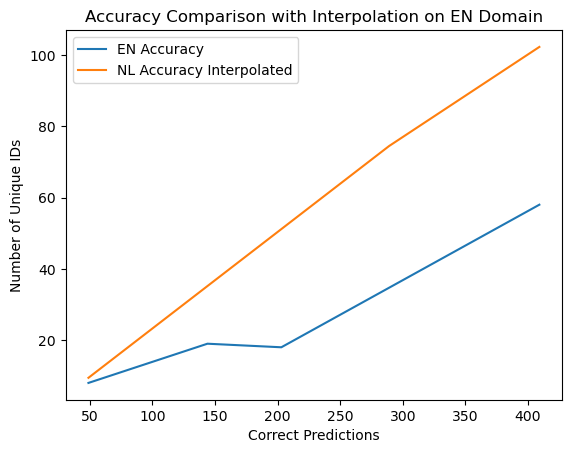

In [63]:
from matplotlib import pyplot as plt
import json
import numpy as np
from scipy.signal import savgol_filter

model_sizes = ["125M", "1.3B", "2.7B", "6B"]

x_nl = []
x_en = []

y_nl = []
y_en = []

def load_unique_exids(path):
    exids = []
    num_correct = None  # Initialize variable to store num_correct
    with open(path, "r") as in_nl:
        first_line = True  # Flag to check if it's the first line
        for line in in_nl:
            if first_line:
                # Extract num_correct from the first line and convert to int
                num_correct = int(json.loads(line)['num_correct'])
                first_line = False  # Update flag so this block doesn't run again
                continue  # Skip the rest of the loop and move to the next iteration
            # For all other lines, extract exid as before
            exids.append(int(json.loads(line)["exid"]))
    return exids, num_correct  # Return both exids and num_correct

for i in range(len(model_sizes)):
    acc_nl = f"tmp/europarl/nl/nl-100-100-{model_sizes[i]}/accuracy.jsonl"
    acc_en = f"tmp/europarl/en/en-100-100-{model_sizes[i]}/accuracy.jsonl"

    nl_exids, nl_correct = load_unique_exids(acc_nl)
    en_exids, en_correct = load_unique_exids(acc_en)

    x_nl.append(nl_correct)
    x_en.append(en_correct)

    y_nl.append(len(nl_exids))
    y_en.append(len(en_exids))

# Adjust the x domain to use the original English domain and shrink the Dutch curve accordingly

# Define the new x domain as the range of x_en
new_x_domain_en = np.linspace(min(x_en), max(x_en), num=len(x_en))

# Interpolate y_nl values over the new x domain of English
new_y_nl = np.interp(new_x_domain_en, x_nl, y_nl)

# Plot using the new_x_domain_en for EN, and the interpolated values for NL

plt.plot(x_en, y_en, label='EN Accuracy')  # Plot for EN using its original domain
plt.plot(new_x_domain_en, new_y_nl, label='NL Accuracy Interpolated')  # Plot for NL interpolated to EN's domain

# Adding labels and legend
plt.xlabel('Correct Predictions')  # Adjust label as per your data
plt.ylabel('Number of Unique IDs')  # Adjust label as per your data
plt.title('Accuracy Comparison with Interpolation on EN Domain')  # Title for your plot
plt.legend()  # To add a legend to differentiate the lines

# Show the plot
plt.show()


In [441]:
epoch = 50

en_acc = f"tmp/EMEA/epoch/en/en-100-100-2.7B-E{epoch}/accuracy.jsonl"
dataset = "EMEA/epoch/100/cropped.en-train.jsonl"

import random 

threshold = 1
data_dict = {}
with open(en_acc, "r") as f, open(dataset, "r") as data:
    en_lines = f.readlines()
    d = data.readlines()

    for line in d:
        obj = json.loads(line)
        data_dict[obj["exid"]] = obj["text"]

    en_exids = set()
    for i,line in enumerate(en_lines[1:]):
        obj = json.loads(line)
        if obj["num_correct"] >= threshold:
            exid = obj["exid"]
            # print(exid)
            en_exids.add(exid)
    
    print(len(en_exids))

print("-------------------")

nl_acc = f"tmp/EMEA/epoch/nl/nl-100-100-2.7B-E{epoch}/accuracy.jsonl"
dataset = "EMEA/epoch/100/cropped.nl-train.jsonl"

data_dict_nl = {}
with open(nl_acc, "r") as f, open(dataset, "r") as data:
    nl_lines = f.readlines()
    d = data.readlines()

    for line in d:
        obj = json.loads(line)
        data_dict_nl[obj["exid"]] = obj["text"]

    nl_exids = set()
    for i,line in enumerate(nl_lines[1:]):
        obj = json.loads(line)
        if obj["num_correct"] >= threshold:
            exid = obj["exid"]
            nl_exids.add(exid)
    
    print(len(nl_exids))

print("-------------------")

inter = en_exids.intersection(nl_exids)
print("inter", len(inter))

difference = en_exids.difference(nl_exids)
print("diff", difference)

print("-------------------")

inter_lines_en = []
for id in list(inter):
    num_correct_en = 0
    num_correct_nl = 0
    num_exact_match_en = 0
    num_exact_match_nl = 0

    for line in en_lines[1:]:
        obj = json.loads(line)
        if obj["exid"] == id:
            num_correct_en = obj["num_correct"]
            num_exact_match_en = obj["num_exact_match"]
            inter_lines_en.append({"exid": id, "text": data_dict[id]})
            break
    
    for line in nl_lines[1:]:
        obj = json.loads(line)
        if obj["exid"] == id:
            num_correct_nl = obj["num_correct"]
            num_exact_match_nl = obj["num_exact_match"]
            break



    # print(id, '&', data_dict[id] , '&', num_correct_en, '&', num_exact_match_en, '&', data_dict_nl[id], '&', num_correct_nl, '&', num_exact_match_nl)
    # print(id, '&', data_dict[id] , '&', num_correct_en, '&', num_exact_match_en, '&', data_dict_nl[id])

    # print("-------------------")


    # print(id, '&', data_dict_nl[id] , '&', num_correct_nl, '&', num_exact_match_nl)    
    # print("")



1000
-------------------
1000
-------------------
inter 1000
diff set()
-------------------


In [442]:
import re
from collections import defaultdict

def find_repetitive_sentences(text):
    sentences = re.split(r'(?<=[.!?])\s+', text)
    
    repetitive_sentences = []
    
    for sentence in sentences:
        words = sentence.split()
        seen_substrings = defaultdict(int)
        
        for i in range(len(words)):
            for j in range(i + 1, len(words) + 1):
                substring = ' '.join(words[i:j])
                seen_substrings[substring] += 1
                if seen_substrings[substring] > 1:
                    repetitive_sentences.append(sentence)
                    break
            if sentence in repetitive_sentences:
                break

        rep_substrings = [substring for substring, count in seen_substrings.items() if count > 1]
    
    return repetitive_sentences, rep_substrings


# Find and print sentences with repetitive substrings
# substring, repetitive_sentences = find_repetitive_sentences(text)



print(len(inter_lines_en))

remove_exids = set()
for line in inter_lines_en:
    text = line["text"]
    substring, repetitive_sentences = find_repetitive_sentences(text)
    # for sentence in repetitive_sentences:
    #     print(sentence)
    #     print(substring)
    
    if(len(repetitive_sentences) > 0):
        remove_exids.add(line["exid"])
    # print("")

print("remove_exids", len(remove_exids))


# save to file
with open(f"EMEA/epoch/emea-rm-exids-E{epoch}.json", "w") as f:
    json.dump(list(remove_exids), f, indent=4)


1000
remove_exids 499
